<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# План выполнения проекта:
1. Загрузим данные и выполним их ресемплирование по одному часу.
2. Проанализируем данные.
3. Обучим разные модели с различными гиперпараметрами.
4. Проверим данные на тестовой выборке.
5. Сделаем выводы.

# Условие:
сделать тестовую выборку размером 10% от исходных данных.

## Подготовка

Импортируем необходимые библиотеки

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.dummy import DummyRegressor

from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.model_selection import GridSearchCV
import lightgbm as lgbm
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OrdinalEncoder
import time

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
#убираем системные предупреждения
warnings.filterwarnings('ignore')

Считаем данные из csv-файла в датафрейм и сохраним в переменную

In [2]:
data_taxi = pd.read_csv('/datasets/taxi.csv')

In [3]:
display(data_taxi.head())

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
print(data_taxi.isna().sum())
print('\nЧисло дубликатов:', data_taxi.duplicated().sum())

datetime      0
num_orders    0
dtype: int64

Число дубликатов: 0


In [5]:
display(data_taxi.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

In [6]:
data_taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [7]:
# Изменим тип данных datetime с object на datetime64
data_taxi['datetime'] = pd.to_datetime(data_taxi['datetime'])

In [8]:
# проверим 
display(data_taxi.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


None

In [9]:
# Установим индекс таблицы равным столбцу Datetime.
data_taxi = data_taxi.set_index('datetime')

In [10]:
# проверим 
display(data_taxi.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

In [11]:
# Проверим хронологию даты и времени
data_taxi = data_taxi.sort_index(ascending=True)
data_taxi.index.is_monotonic

True

In [12]:
# проверим 
display(data_taxi.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

<AxesSubplot:xlabel='datetime'>

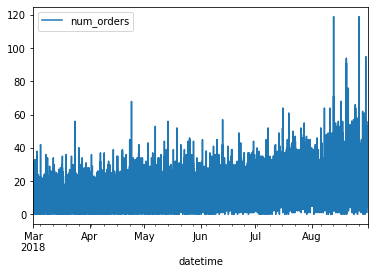

In [13]:
# посторим график временного ряда
data_taxi.plot()

In [14]:
# выполним ресемплирование по 1 часу
data_taxi = data_taxi.resample('1H').sum()
data_taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод по шагу 1:**
1. Данные загружены и изучены.
2. Пропуски и дубликаты отсутствуют.
3. Выполнена индексация по столбцу Datetime.
4. Выполнено ресемплирование по 1 часу по условию задачи.

## Анализ

<AxesSubplot:xlabel='datetime'>

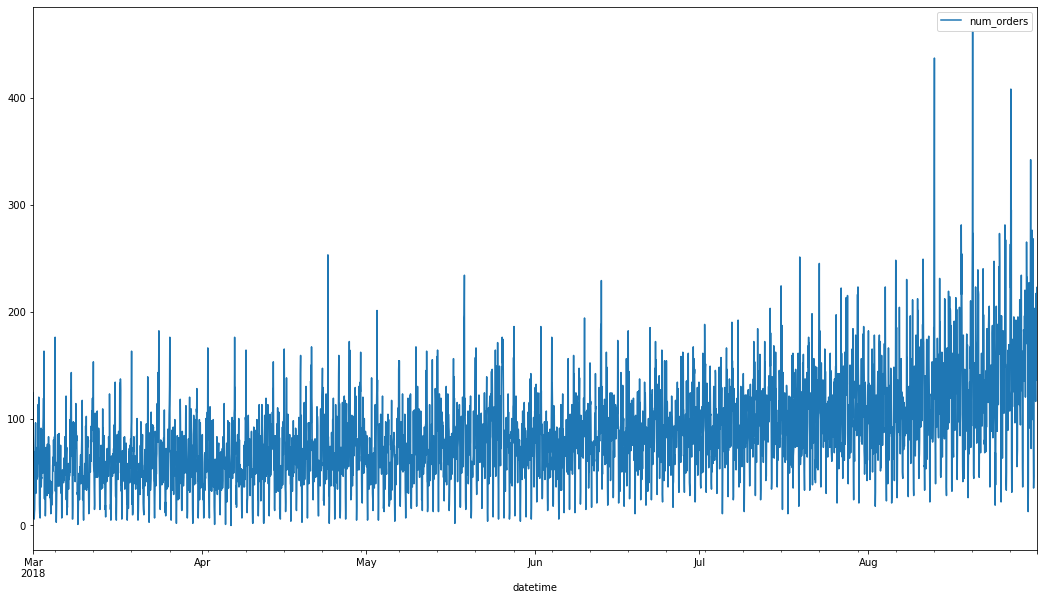

In [15]:
# построим график
data_taxi.plot(figsize=(18,10))

Пока мало что понятно, рассмотрим меньший период.

<AxesSubplot:xlabel='datetime'>

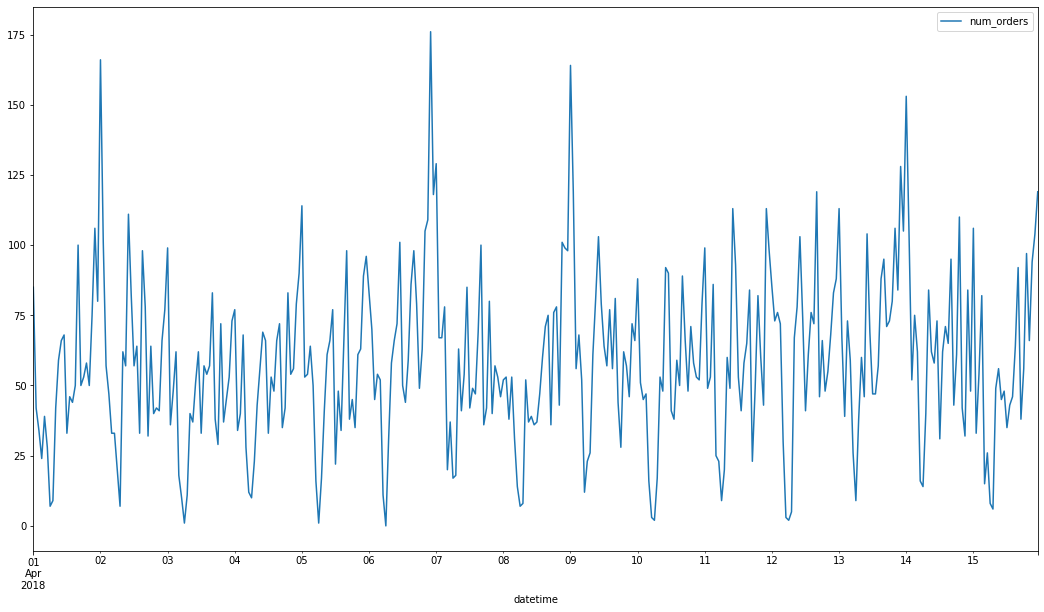

In [16]:
data_taxi['2018-04-01':'2018-04-15'].plot(figsize=(18,10))

In [17]:
data_taxi.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [18]:
data_taxi.sort_index(inplace=True)

In [19]:
# рассмотрим тренды, сезонность и остаток декомпозиции заказа такси
decomposed = seasonal_decompose(data_taxi)

<AxesSubplot:xlabel='datetime'>

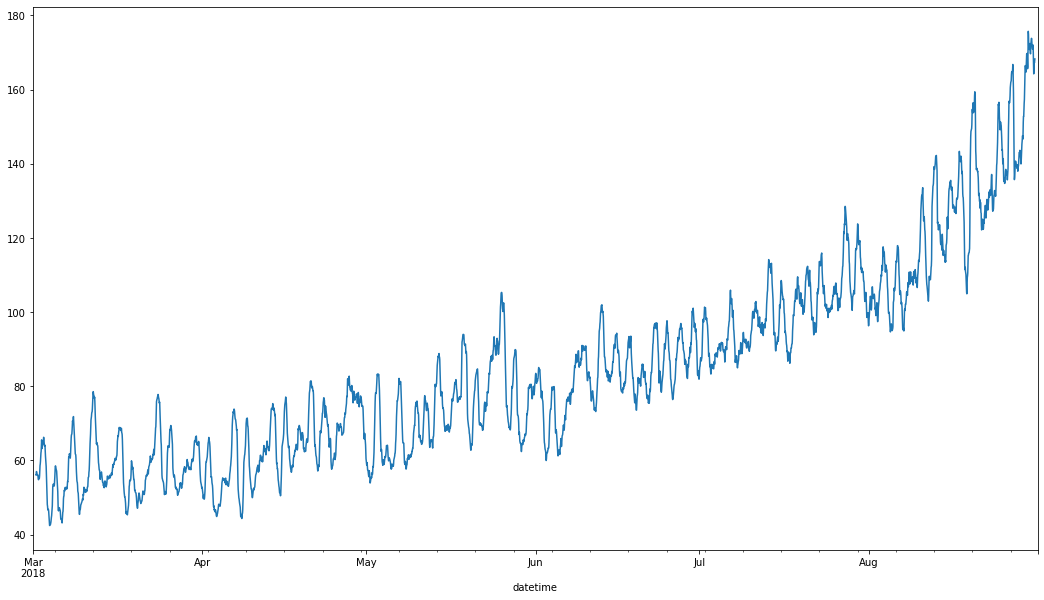

In [20]:
decomposed.trend.plot(figsize=(18,10))

<AxesSubplot:xlabel='datetime'>

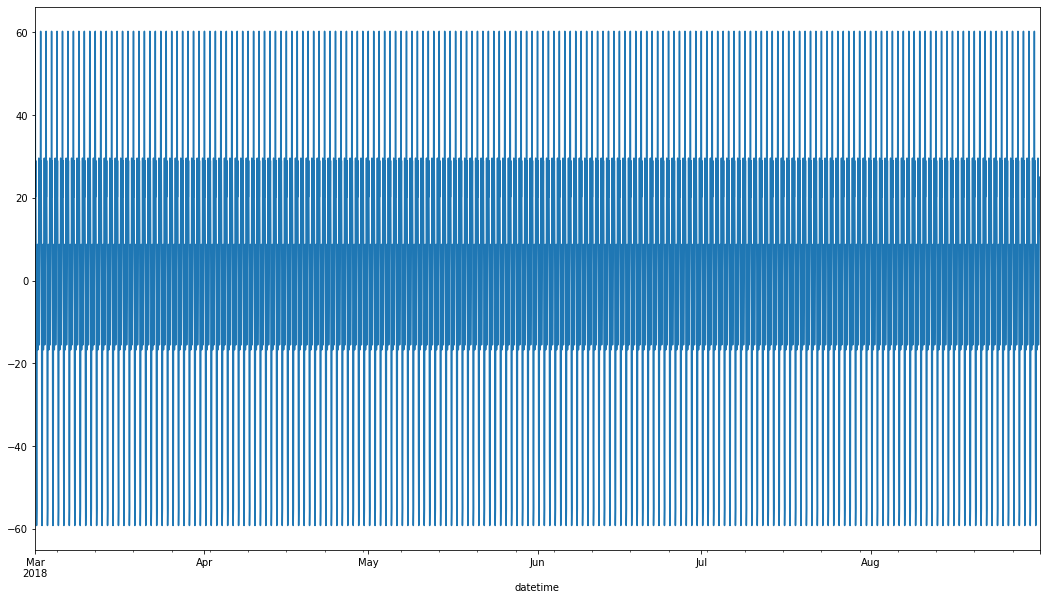

In [21]:
decomposed.seasonal.plot(figsize=(18,10))

<AxesSubplot:xlabel='datetime'>

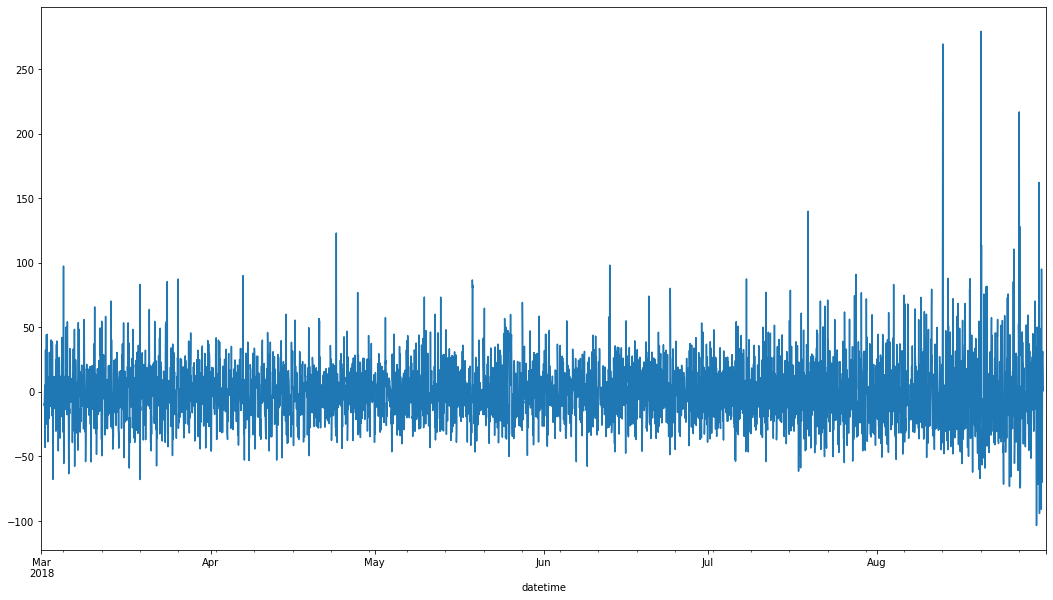

In [22]:
decomposed.resid.plot(figsize=(18,10))

Чтобы было понятнее, возьмем другой временной период и опять рассмотрим тренды, сезонность и остаток декомпозиции заказа такси.

In [23]:
decomposed = seasonal_decompose(data_taxi['2018-04-01':'2018-04-15'])

<AxesSubplot:xlabel='datetime'>

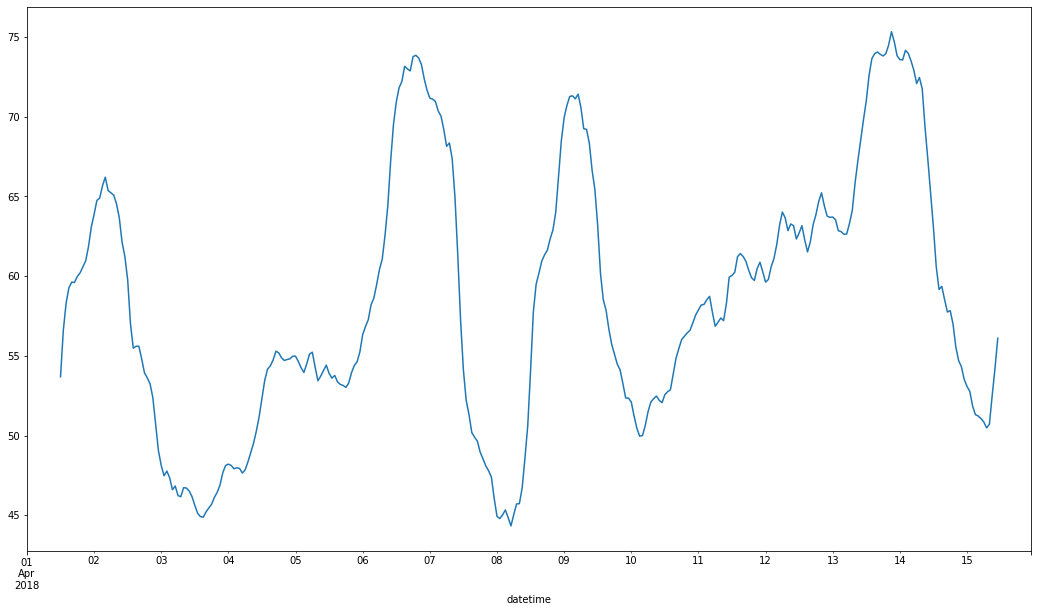

In [24]:
decomposed.trend.plot(figsize=(18,10))

<AxesSubplot:xlabel='datetime'>

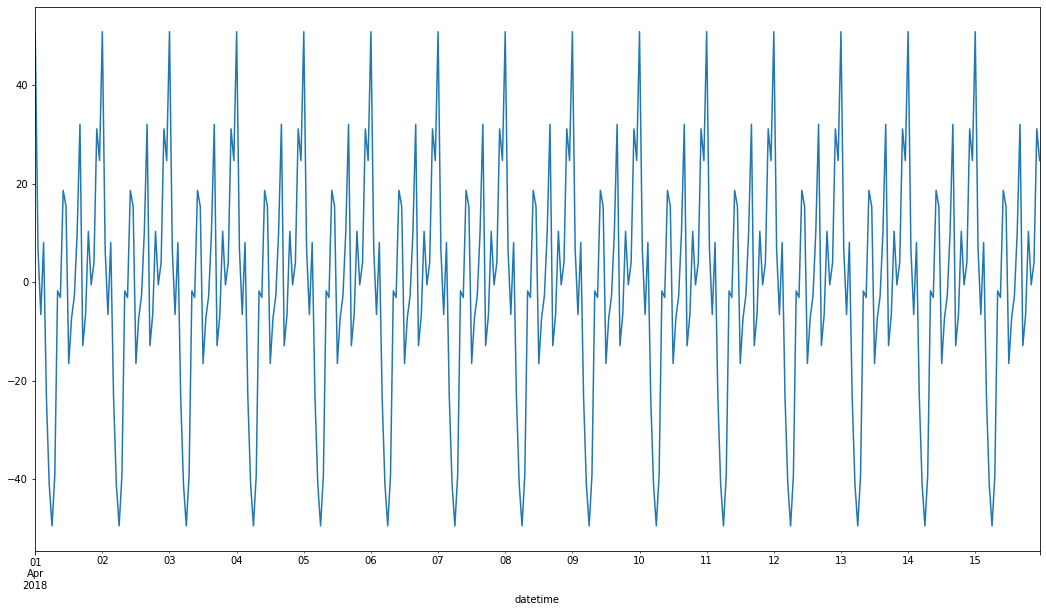

In [25]:
decomposed.seasonal.plot(figsize=(18,10))

<AxesSubplot:xlabel='datetime'>

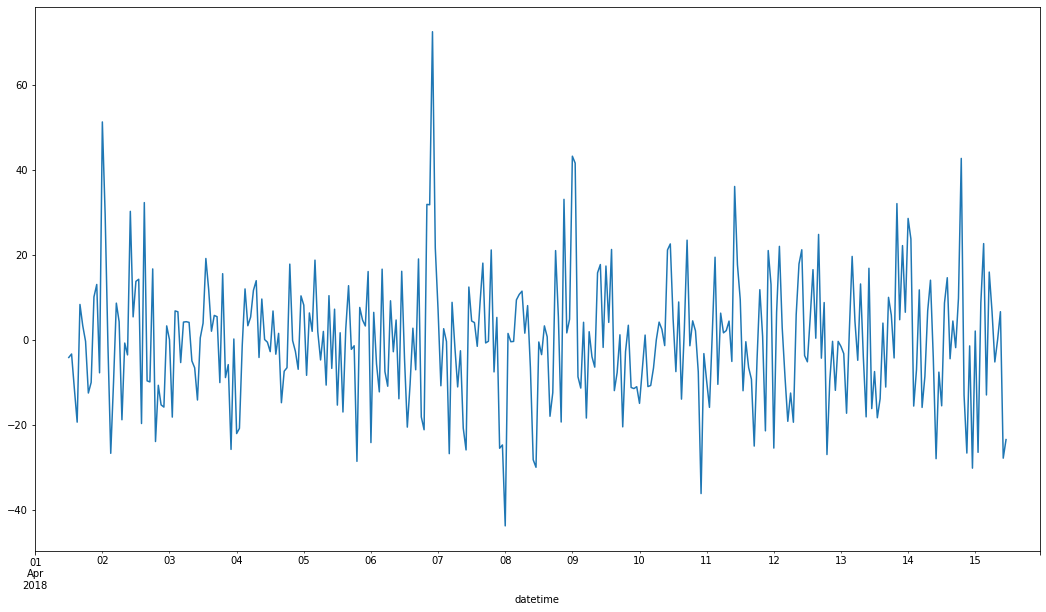

In [26]:
decomposed.resid.plot(figsize=(18,10))

Из теории по тренажеру: "Стационарные временные ряды (англ. stationary time series) — это ряды, у которых среднее и стандартное отклонение не меняются. Когда среднее и стандартное отклонение первого ряда меняется медленнее второго, то первый ряд «более стационарный», чем второй.". Разности временного ряда более стационарны, чем сам ряд.

<AxesSubplot:xlabel='datetime'>

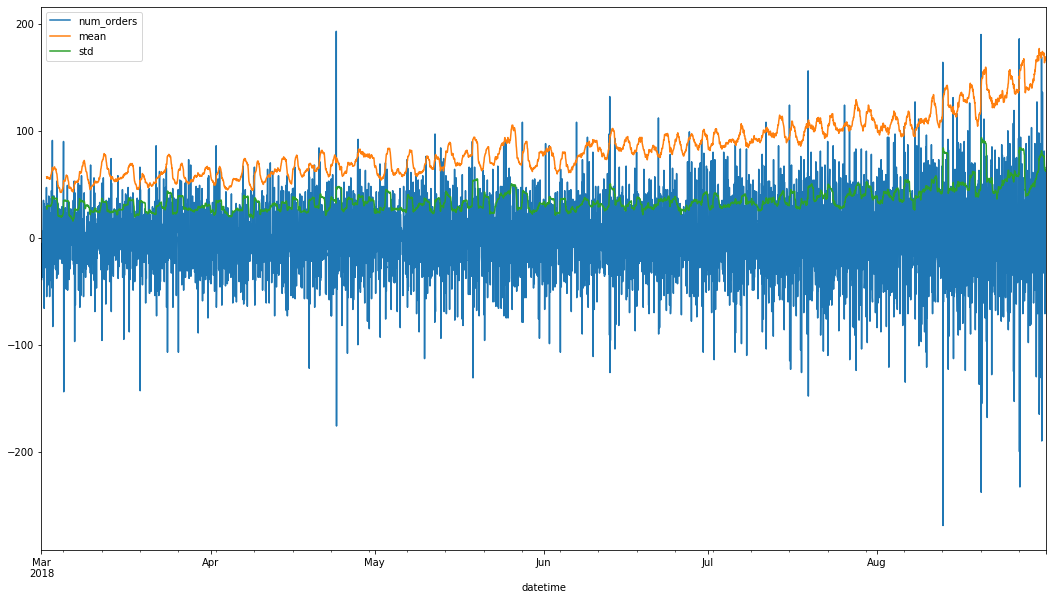

In [27]:
data_taxi_shift = data_taxi - data_taxi.shift() 
data_taxi_shift['mean'] = data_taxi['num_orders'].rolling(24).mean()
data_taxi_shift['std'] = data_taxi['num_orders'].rolling(24).std()
data_taxi_shift.plot(figsize=(18,10))

**Вывод по шагу 2:**
1. По первому графику (тренд) видно увеличение заказов.
2. По второму графику (сезонность) видно увеличение спроса в ночное время (пики в 0:00 часов), что логично, так как общественный транспорт ночью не работает, или работает с большими перерывами.
3. В утренние часы количество заказов резко падает.
4. В данном случае, временной ряд не является стационарным, так как подвержен тренду, который меняется во времени. 

## Обучение

In [28]:
# для расчёта целевой метрики используем RMSE и напишем функцию.
def rmse(test,predict):
    return ((mean_squared_error(test,predict))**0.5).round(2)

In [29]:
# создание функции по созданию признаков
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
         
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [30]:
data_taxi_copy = data_taxi.copy() # создание нового датафрейма по комментариям

make_features(data_taxi, 25, 48) # произвольные значения аргументов

data_taxi.head()

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# удалим пропуски
data_taxi = data_taxi.dropna()

In [32]:
data_taxi.head()

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,3,5,72.0,119.0,101.0,93.0,49.0,89.0,83.0,...,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,59.791667
2018-03-03 01:00:00,108,3,5,163.0,72.0,119.0,101.0,93.0,49.0,89.0,...,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,60.604167
2018-03-03 02:00:00,25,3,5,108.0,163.0,72.0,119.0,101.0,93.0,49.0,...,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,61.083333
2018-03-03 03:00:00,64,3,5,25.0,108.0,163.0,72.0,119.0,101.0,93.0,...,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,60.125000
2018-03-03 04:00:00,44,3,5,64.0,25.0,108.0,163.0,72.0,119.0,101.0,...,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,60.083333


In [33]:
# выделим признаки и целевой признак
features = data_taxi.drop(['num_orders'], axis=1)
target = data_taxi['num_orders']

In [34]:
# напишем функцию, котторая будет собирать данные, важные для заказчика, в сводную таблицу для анализа
def taxi_table(RMSE,model_name,data_taxi):
    data_taxi.loc[model_name,'Model'] = model_name
    data_taxi.loc[model_name,'RMSE'] = RMSE
    return data_taxi

In [35]:
# это будет сводная таблица
taxi_result = pd.DataFrame(columns=['Model','RMSE'])
taxi_result

,Model,RMSE


In [36]:
# разделим на обучающую, валидационную и тестовую выборки
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.2, shuffle=False, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, shuffle=False, random_state=12345)

In [37]:
print(features_train.shape, features_train.index.min(), features_train.index.max())

(3494, 28) 2018-03-03 00:00:00 2018-07-26 13:00:00


In [38]:
print(features_valid.shape, features_valid.index.min(), features_valid.index.max())

(437, 28) 2018-07-26 14:00:00 2018-08-13 18:00:00


In [39]:
print(features_test.shape, features_test.index.min(), features_test.index.max())

(437, 28) 2018-08-13 19:00:00 2018-08-31 23:00:00


### LinearRegression

In [40]:
model_lr=LinearRegression(normalize=True) # объявляем модель
model_lr.fit(features_train, target_train) # обучаем модель
predict_lr = model_lr.predict(features_valid) # получение предсказания модели

In [41]:
rmse_lr=rmse(target_valid, predict_lr)
print('RMSE модели Линейная Регрессия равна:', rmse_lr)

RMSE модели Линейная Регрессия равна: 34.44


In [42]:
taxi_table(rmse_lr,'LinearRegression',taxi_result) # добавим данные в сводную таблицу

,Model,RMSE
LinearRegression,LinearRegression,34.44


### RandomForestRegressor

In [43]:
# подберем гиперпараметр max_depth
for depth in range(2, 10, 2):
    model_forest = RandomForestRegressor(random_state=12345, max_depth = depth)
    model_forest.fit(features_train, target_train)
    predict_forest = model_forest.predict(features_valid)
    rmse_forest = rmse(target_valid, predict_forest)
    print('Глубина:', depth)
    print('RMSE для решающего дерева:', rmse_forest)
    print('')
print()

Глубина: 2
RMSE для решающего дерева: 44.7

Глубина: 4
RMSE для решающего дерева: 40.27

Глубина: 6
RMSE для решающего дерева: 37.05

Глубина: 8
RMSE для решающего дерева: 35.17




In [44]:
# подберем гиперпараметр n_estimators
for est in [100, 500, 1000]:
    model_forest = RandomForestRegressor(random_state=12345, 
                                   n_estimators=est, 
                                   max_depth=8)
    model_forest.fit(features_train, target_train)
    predict_forest = model_forest.predict(features_valid)
    rmse_forest = rmse(target_valid, predict_forest)
    print('Количество деревьев:', est)
    print('RMSE для случайного леса:', rmse_forest)
    print('')
print()

Количество деревьев: 100
RMSE для случайного леса: 35.17

Количество деревьев: 500
RMSE для случайного леса: 35.03

Количество деревьев: 1000
RMSE для случайного леса: 34.96




In [45]:
# обучаем модель на найденных гиперпараметрах
model_forest=RandomForestRegressor(random_state=12345, 
                                   n_estimators=1000, 
                                   max_depth=8) # объявляем модель
model_forest.fit(features_train, target_train) # обучаем модель
predict_forest = model_forest.predict(features_valid) # получение предсказания модели

In [46]:
rmse_forest=rmse(target_valid, predict_forest)
print('RMSE модели Случайный лес равна:', rmse_forest)

RMSE модели Случайный лес равна: 34.96


In [47]:
taxi_table(rmse_forest,'RandomForestRegressor',taxi_result) # добавим данные в сводную таблицу

,Model,RMSE
LinearRegression,LinearRegression,34.44
RandomForestRegressor,RandomForestRegressor,34.96


### CatBoostRegressor

In [48]:
best_result = 5000
depth = 0
depths = []
results = []

for depth in range(1, 21, 5):
    model_catboost = CatBoostRegressor(iterations=60, learning_rate=0.1, max_depth=depth, random_state=12345, verbose=False)
    model_catboost.fit(features_train, target_train)
    predictions_valid = model_catboost.predict(features_valid)
    result = rmse(target_valid, predictions_valid)
    depths.append(depth)
    results.append(result)
   
    if result < best_result:
        best_depth = depth
        best_result = result

display(best_result, best_depth)

34.83

6

In [49]:
model_catboost = CatBoostRegressor(iterations=60, learning_rate=0.1, max_depth=6, random_state=12345, verbose=False)
model_catboost.fit(features_train, target_train, eval_set=(features_valid,target_valid))
predict_catboost = model_catboost.predict(features_valid)

In [50]:
print(' Гиперпараметры модели:\n',model_catboost)

 Гиперпараметры модели:


In [51]:
rmse_catboost=rmse(target_valid, predict_catboost)
print('RMSE модели CatBoostRegressor равна:', rmse_catboost)

RMSE модели CatBoostRegressor равна: 34.83


In [52]:
taxi_table(rmse_catboost,'CatBoostRegressor',taxi_result) # добавим данные в сводную таблицу

,Model,RMSE
LinearRegression,LinearRegression,34.44
RandomForestRegressor,RandomForestRegressor,34.96
CatBoostRegressor,CatBoostRegressor,34.83


**Вывод по шагу 3:**
1. создана функция для rmse.
2. создана функция для создания признаков.
3. выделены признаки и целевой признак.
4. провели разделение на обучающую, валидационную и тестовую выборки.
5. обучили три модели: LinearRegression, RandomForestRegressor и CatBoostRegressor.

## Тестирование

In [53]:
# проверка модели на адекватность с помощью предыдущего значения ряда
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

print('RMSE для проверки модели на адекватность:', round(rmse(target_test, pred_previous), 2))

RMSE для проверки модели на адекватность: 59.02


Для тестирования берем лучшую модель. В нашем случае лучшие данные по rmse показала модель LinearRegression (34.44).

In [54]:
#predict_forest = model_forest.predict(features_test)
#rmse_forest_test=rmse(target_test, predict_forest)
#print('RMSE модели Случайный лес равна:', rmse_forest_test)
#taxi_table(rmse_forest_test,'RandomForestRegressorTest',taxi_result) # добавим данные в сводную таблицу

Неожиданно для меня, на тестовой выборке данная модель показала результат 49.11, что не соответствует требованию заказчика (rmse не больше 48). Таким образом, проверим на тестовой выборке остальные модели.

In [55]:
#predict_catboost = model_catboost.predict(features_test)
#rmse_catboost_test=rmse(target_test, predict_catboost)
#print('RMSE модели CatBoostRegressorTest равна:', rmse_catboost_test)
#taxi_table(rmse_catboost_test,'CatBoostRegressorTest',taxi_result) # добавим данные в сводную таблицу

In [56]:
predict_lr = model_lr.predict(features_test)
rmse_lr_test=rmse(target_test, predict_lr)
print('RMSE модели Линейная Регрессия равна:', rmse_lr_test)
taxi_table(rmse_lr_test,'LinearRegressionTest',taxi_result) # добавим данные в сводную таблицу

RMSE модели Линейная Регрессия равна: 45.41


,Model,RMSE
LinearRegression,LinearRegression,34.44
RandomForestRegressor,RandomForestRegressor,34.96
CatBoostRegressor,CatBoostRegressor,34.83
LinearRegressionTest,LinearRegressionTest,45.41


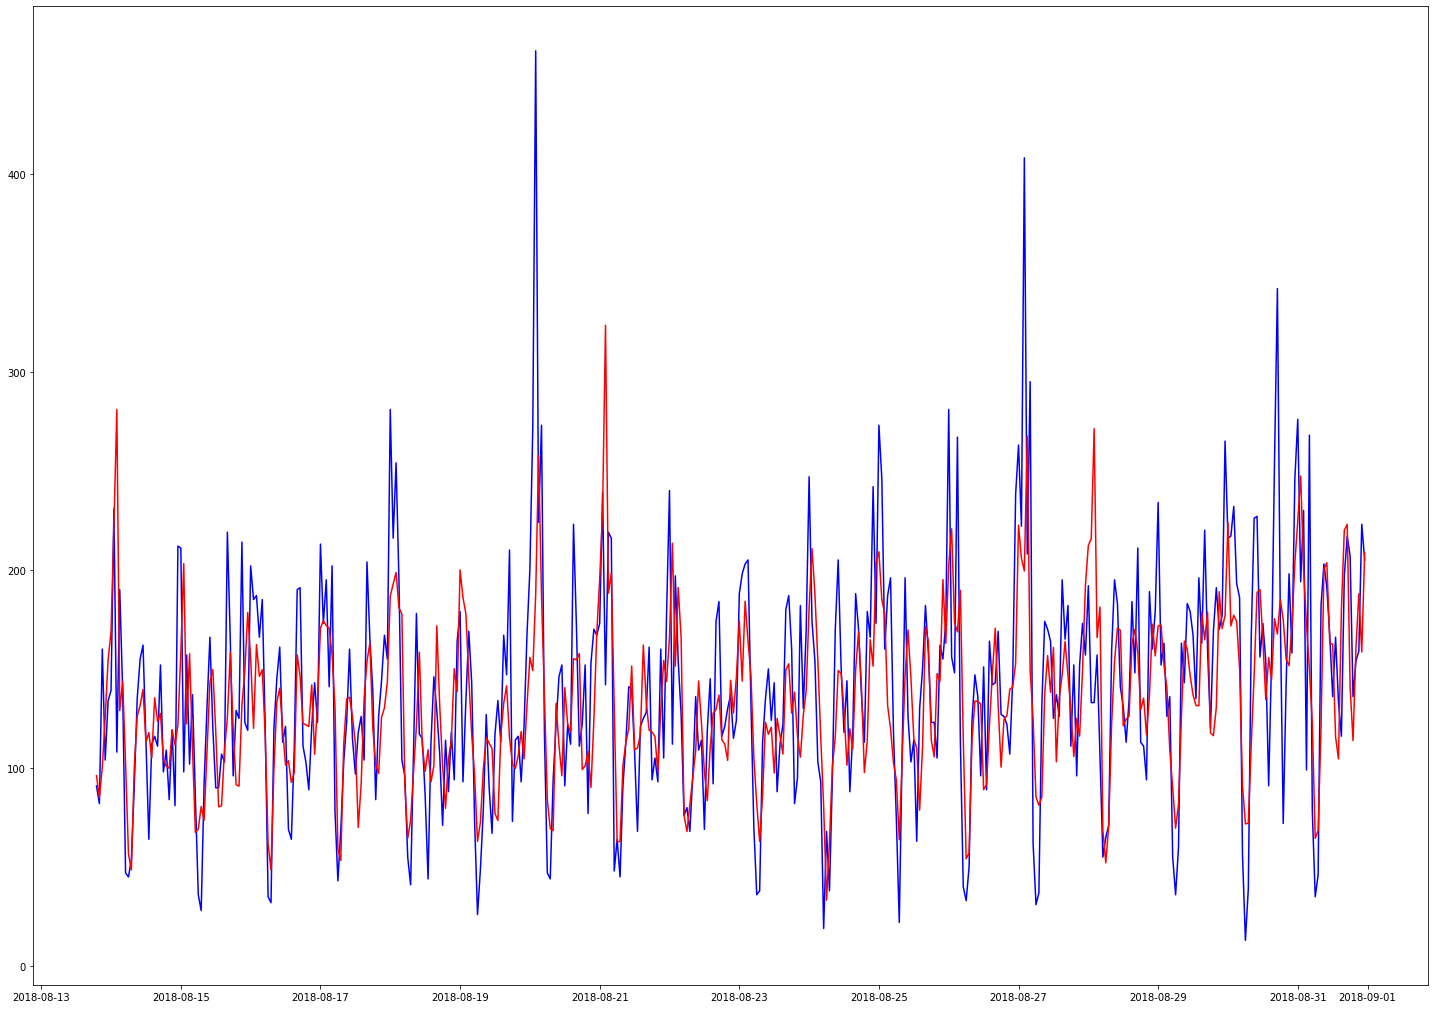

In [57]:
plt.figure(figsize=(25,18))
plt.plot(target_test.index,
        target_test,
        'b-',
        target_test.index,
        predict_lr,
        'r-')

# Общий вывод:

При выполнении проекта проделана следующая работа:
1. На первом этапе произведена загрузка данных и их изучение. Был изменен тип данных Datetime с object на datetime64 и выполнена индексация по столбцу Datetime. Выполнено ресемплирование по 1 часу по условию задачи (изначально данные за каждые 10 минут).
2. Далее мы проанализировали графики временного ряда, сначала по всем данным, потом по данным с 01 по 15 апреля. Был выявлен тренд на увеличение количества заказов с течением времени, а также то, что пик заказов приходится на 12 ночи, а минимум наблюдается к утру.
3. Затем мы создали календарные признаки для месяца, дня, дня недели и часа и отстающие признаки, а также скользящее среднее. Удалили пропуски и получили таблицу с 30 колонками.
4. провели разделение на обучающую, валидационную и тестовую выборки и обучили три модели: LinearRegression, RandomForestRegressor и CatBoostRegressor. 
5. Протестировали на тестовых данных и получили значение RMSE 45.4 у модели LinearRegression.